In [1]:
state = 'ME' 
year = 2020

In [2]:
import sys, os
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [3]:
filepath = '../../dat/' + str(year) + '/'
filename = state + '_county.json'
filename2 = state + '_county.shp'

In [4]:
from read import read_graph_from_json
from epsilon_constraint import*
import networkx as nx

G = read_graph_from_json(state, filepath + filename, year=year)
print(f"The state of {state} has {G._k} districts.")
G._ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of ME has 2 districts.


In [5]:
#import warm starts
sys.path.append(os.path.abspath('../heuristic'))

from ME_plans_2020 import plans
print(f"Loaded {len(plans)} plans from file.")
warm_starts = plans

Loaded 8 plans from file.


In [6]:
obj_type = 'bottleneck_Polsby_Popper'
starting_deviation = 0.01 
verbose = True
contiguity = 'lcut'               # {'lcut', 'scf', 'shir'}
warm_start_mode = 'user'          # {'None', 'user', 'refinement'}
warm_starts = warm_starts         # if you have user define warm starts else it is None
time_limit = 7200                 # Time limit in seconds, adjust as needed
multiplier = 0                    # Adjust multiplier as needed
max_B = True                      # If symmetry_breaking is 'orbitope' or you have warm_start, max_B should be True
symmetry_breaking = 'orbitope'    # {None, 'orbitope', 'rsum'}              
sizes = None

In [7]:
print(f"Running epsilon constraint method for state {state}, objective {obj_type}")
print(f"{'#' * 100}\n")
(plans, obj_bounds, deviations) = epsilon_constraint_method(
            G,                 
            obj_type,          
            contiguity,        
            cutoff=None,       
            verbose=verbose,
            warm_start_mode = warm_start_mode,
            warm_starts=warm_starts,  
            starting_deviation=starting_deviation, 
            time_limit=time_limit, 
            sizes=sizes,      
            max_B=max_B,      
            symmetry_breaking=symmetry_breaking, 
        )

Running epsilon constraint method for state ME, objective bottleneck_Polsby_Popper
####################################################################################################

L = 674368 and U = 687991

****************************************
Trying deviation = 6811.795
****************************************
Using user-provided warm starts.
Selected warm_start = [[0, 3, 6, 12], [1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15]]
Objective value: 0.2778545795073467
Deviation: 2777.5

****************************************
Running labeling model!
****************************************
L = 674368 and U = 687991
Set parameter Username
Set parameter LicenseID to value 2608266
Academic license - for non-commercial use only - expires 2026-01-09
sizes =  [1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Applying warm start!
Set parameter MIPGap to value 0
Set parameter FeasibilityTol


User-callback calls 986, time in user-callback 0.02 sec

****************************************
Optimal solution found! Gurobi status: 2
****************************************
[[1, 2, 3, 4, 9, 10, 11, 12, 14, 15], [0, 5, 6, 7, 8, 13]]

****************************************
Trying deviation = 1882.25
****************************************
Using user-provided warm starts.
Selected warm_start = [[5, 6, 7, 8, 10, 12, 13, 14], [0, 1, 2, 3, 4, 9, 11, 15]]
Objective value: 0.12938101738023425
Deviation: 750.5

****************************************
Running labeling model!
****************************************
L = 679298 and U = 683061
sizes =  [1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Applying warm start!
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Opt

In [8]:
result = list(zip(plans, obj_bounds , deviations))

In [9]:
# Determine the senses for the Pareto frontier
# Minimize the first objective ('deviation').
# Maximize the second objective for compactness types, otherwise minimize it.
senses = ['min', 'max' if obj_type in ['average_Polsby_Popper','bottleneck_Polsby_Popper'] else 'min']
obj_names = ['deviation_persons', obj_type]
infeasible_region = [0, min(round(r[2],1) for r in result)]


####################################################################################################
Pareto Frontier for state ME,  objective bottleneck_Polsby_Popper
####################################################################################################

Pareto front plans: [[[5, 6, 7, 8, 10, 12, 13, 14], [0, 1, 2, 3, 4, 9, 11, 15]], [[1, 2, 3, 4, 9, 10, 11, 12, 14, 15], [0, 5, 6, 7, 8, 13]], [[0, 3, 6, 12], [1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15]]]
Pareto front upper bounds: [[750.5, 0.12938101738023422], [1882.5, 0.16315877430560263], [2777.5, 0.27785457950734666]]
Pareto front lower bounds: [[750.5, 0.12938101738023422], [1882.5, 0.16315877430560263], [2777.5, 0.27785457950734666]]


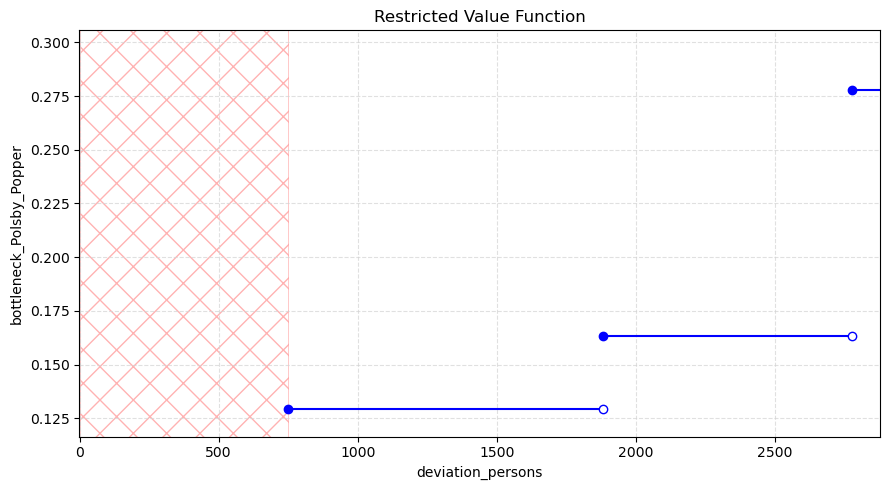

In [10]:
from pareto import ParetoFrontier

print(f"\n{'#' * 100}\nPareto Frontier for state {state},  objective {obj_type}\n{'#' * 100}\n")
pareto = ParetoFrontier(senses, obj_names, state=state, level='county')

if not  plans:
    print("No plan found!")
else:
    for plan, obj_bound, dev in result:
        upper_bound = [dev,  1/obj_bound[0] if  obj_type == 'bottleneck_Polsby_Popper' else obj_bound[0]]
        lower_bound = [dev,  1/obj_bound[1] if  obj_type == 'bottleneck_Polsby_Popper' else obj_bound[1]]
        
        pareto.add_plan(plan, upper_bound, lower_bound)
            
print("Pareto front plans:", pareto.plans)
print("Pareto front upper bounds:", pareto.upper_bounds)
print("Pareto front lower bounds:", pareto.lower_bounds) 

extra_points = None
extra_colors = None
        
pareto.tighten_lower_bounds()

if infeasible_region[1] > 0.5:
    max_dev = max(upper_bound[0] for upper_bound in pareto.upper_bounds)
    max_obj = max(upper_bound[1] for upper_bound in pareto.upper_bounds)
    min_obj = min(upper_bound[1] for upper_bound in pareto.upper_bounds)
    o1lim=[-1, max_dev+100]
    o2lim=[min_obj*0.9, max_obj*(1.1)]
else:
    o1lim = None
    o2lim = None

pareto.plot_with_custom_x_ranges(method = 'epsilon_constraint_method', 
                                 o1lim=o1lim, o2lim=o2lim, infeasible_region = infeasible_region,
                                 extra_points=extra_points, extra_colors=extra_colors)


####################################################################################################
Pareto maps for state ME, objective bottleneck_Polsby_Popper
####################################################################################################



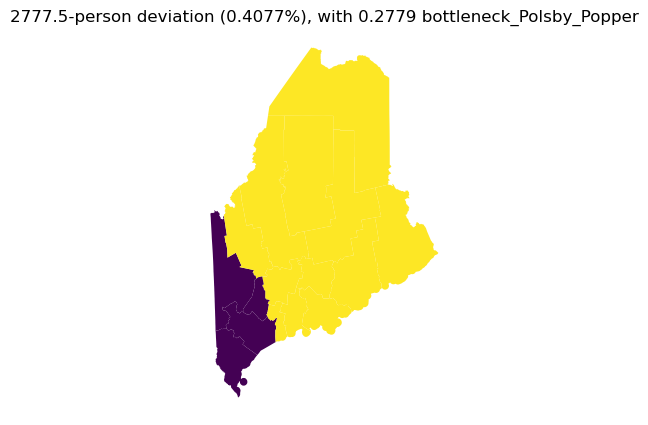

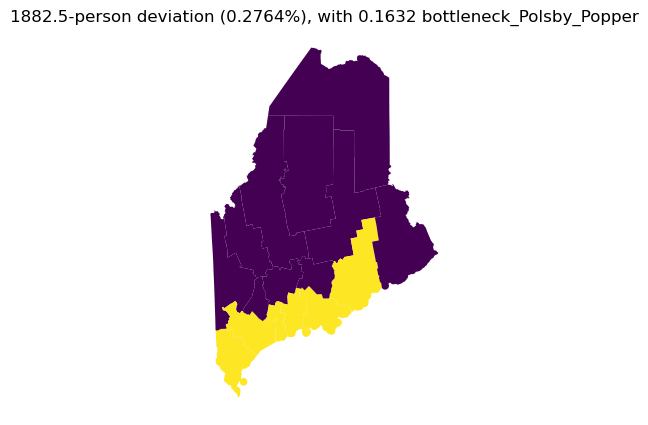

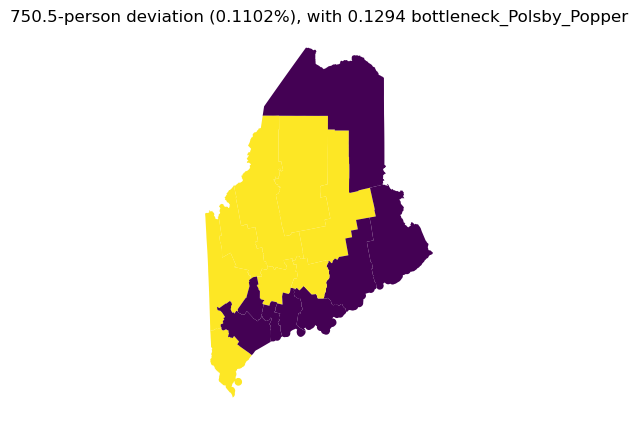

In [11]:
from draw import *

print(f"\n{'#' * 100}\nPareto maps for state {state}, objective {obj_type}\n{'#' * 100}\n")

format_obj = {
    'bottleneck_Polsby_Popper': lambda x: round(1 /x, 4),
    'cut_edges': lambda x: round(x, 0)}

for plan, obj_bound, dev in result:
    ub = format_obj.get(obj_type, lambda x: round(x, 4))(obj_bound[0])
    lb = format_obj.get(obj_type, lambda x: round(x, 4))(obj_bound[1])
    deviation_percentage = round(100 * dev / G._ideal_population, 4)
    if ub != lb:
        title = f"{round(dev, 2)}-person deviation ({deviation_percentage}%), obj_bounds [{ub}, {lb}] {obj_type}"
    else:
        title = f"{round(dev, 2)}-person deviation ({deviation_percentage}%), with {ub} {obj_type}"

    draw_plan(filepath, filename2, G, plan, title=title, year=year)